# Cars Recognition

The goal of this project is to create a neural network capable of recognizing car brands from a photograph.

In [78]:
import os, re, math, random, time, gc, string, pickle, shutil, pathlib, itertools
import numpy as np, pandas as pd, matplotlib.pyplot as plt, PIL

import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.activations import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *
from tensorflow.keras.layers.experimental.preprocessing import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers.schedules import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
from IPython.display import clear_output
from tqdm.notebook import tqdm

In [56]:
sample_submission_path = "./sf-dl-car-classification_project_7/sample-submission.csv"
train_path = "./sf-dl-car-classification_project_7/train"
sub_path = "./sf-dl-car-classification_project_7/test_upload"


We need to classify cars belonging to 10 classes. The distribution among these classes is fairly even

<AxesSubplot:xlabel='Category'>

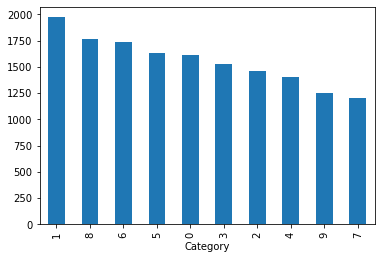

In [32]:
train_df = pd.read_csv(train_path+"/train.csv")
train_df.Category.value_counts().plot(kind = "bar", xlabel = "Category")

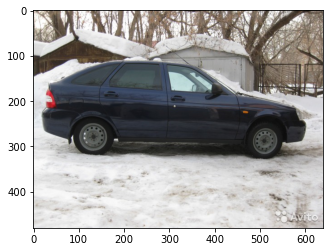

(640, 480)

In [45]:
image = PIL.Image.open(train_path+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

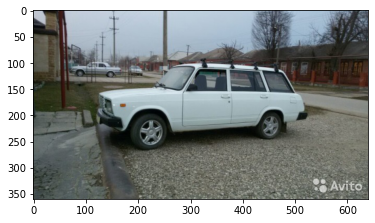

(640, 360)

In [49]:
image = PIL.Image.open(sub_path  +"/805.jpg")
imgplot = plt.imshow(image)
plt.show()
image.size

In [114]:
image_size = (90, 120)
batch_size = 32
RANDOM_SEED = 42
input_shape = (*image_size, 3)

In [264]:
train_datagen = ImageDataGenerator(
    #rescale=1/255,
    validation_split=0.2,
    # ниже параметры аугментаций:
    horizontal_flip=True,
    rotation_range=10,
    shear_range=0.2,
    brightness_range=(0.8, 1.2),
)

val_datagen = ImageDataGenerator(
    #rescale=1/255,
    validation_split=0.2,
)

sub_datagen = ImageDataGenerator(
    #rescale=1/255
)

In [237]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=0,
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=0,
    subset='validation'
)

sub_generator = sub_datagen.flow_from_dataframe( 
    dataframe=pd.read_csv(sample_submission_path),
    directory=sub_path,
    x_col="Id",
    y_col=None,
    class_mode=None,
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.


Train:


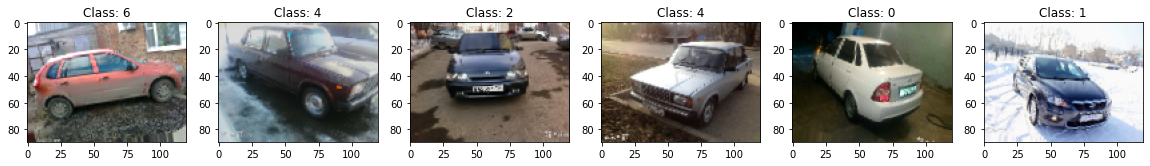

Val:


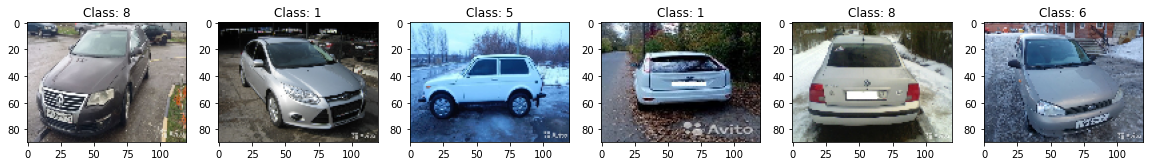

Sub:


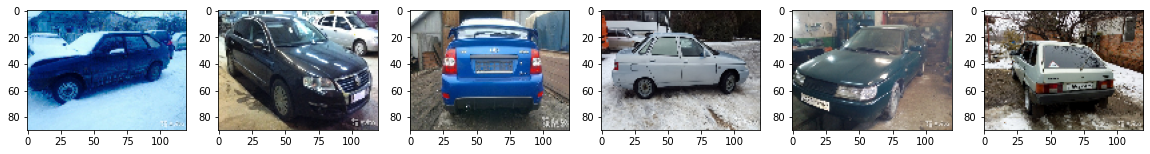

In [61]:
def show_first_images(generator, count=6, labels=True, figsize=(20, 5), normalized=False):
  generator = itertools.islice(generator, count)
  fig, axes = plt.subplots(nrows=1, ncols=count, figsize=figsize)
  for batch, ax in zip(generator, axes):
    if labels:
      img_batch, labels_batch = batch
      img, label = img_batch[0], np.argmax(labels_batch[0]) #берем по одному изображению из каждого батча
    else:
      img_batch = batch
      img = img_batch[0]
    if not normalized:
      img = img.astype(np.uint8)
    ax.imshow(img)
    # метод imshow принимает одно из двух:
    # - изображение в формате uint8, яркость от 0 до 255
    # - изображение в формате float, яркость от 0 до 1
    if labels:
      ax.set_title(f'Class: {label}')
  plt.show()

print('Train:')
show_first_images(train_generator)

print('Val:')
show_first_images(val_generator)

print('Sub:')
show_first_images(sub_generator, labels=False)

In [283]:
model = Sequential([
  EfficientNetB0(weights='imagenet', input_shape=(*image_size, 3), include_top=False), #предобученная нейросеть из модуля keras.applications
  GlobalMaxPool2D(),
  Dropout(0.5),
  Dense(10)
])

model.compile(
    loss=CategoricalCrossentropy(from_logits=True),
    optimizer=Adam(ExponentialDecay(1e-3, 100, 0.9)),
    metrics='accuracy'
)

In [284]:
model.fit(train_generator, validation_data=val_generator, epochs=1)

390/390 [==============================] - 722s 2s/step - loss: 2.4332 - accuracy: 0.3113 - val_loss: 2.3986 - val_accuracy: 0.1039


# Fine-tuning

#### Step 1

Instantiate a base model and freeze it

In [265]:
base_model_02= EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)
base_model_02.trainable = False

Create a new model on top of the base model

In [267]:
model_02=Sequential()
model_02.add(base_model_02)
model_02.add(GlobalAveragePooling2D(),)
model_02.add(Dense(10, activation='softmax'))
model_02.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional)  (None, 3, 4, 2560)       64097687  
                                                                 
 global_average_pooling2d_17  (None, 2560)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_14 (Dense)            (None, 10)                25610     
                                                                 
Total params: 64,123,297
Trainable params: 25,610
Non-trainable params: 64,097,687
_________________________________________________________________


In [268]:
print(len(model_02.layers))
print(len(model_02.trainable_variables))

3
2


check whether the base model is frozen

In [269]:
for layer in model_02.layers:
    print(layer, layer.trainable)

<keras.engine.functional.Functional object at 0x00000216B4361FD0> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x00000216B4252FD0> True
<keras.layers.core.dense.Dense object at 0x00000216239D4580> True


In [270]:
#model_02.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])
model_02.compile(loss=CategoricalCrossentropy(from_logits=True),
    optimizer=Adam(ExponentialDecay(1e-3, 100, 0.9)),
    metrics='accuracy')

In [271]:
scores = model_02.evaluate(val_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

98/98 [==============================] - 292s 3s/step - loss: 2.8769 - accuracy: 0.0981
Accuracy: 9.81%


In [272]:
# Обучаем
history = model_02.fit(
                    train_generator,
                    steps_per_epoch = train_generator.samples//train_generator.batch_size,
                    validation_data = val_generator, 
                    validation_steps = val_generator.samples//val_generator.batch_size,
                    epochs = 5,
                    callbacks = callbacks_list
                    )

Epoch 1/5
97/97 [==============================] - ETA: 0s - loss: 2.4817 - accuracy: 0.0999
Epoch 00001: saving model to best_model.hdf5
97/97 [==============================] - 602s 6s/step - loss: 2.4817 - accuracy: 0.0999 - val_loss: 2.4097 - val_accuracy: 0.1050
Epoch 2/5
97/97 [==============================] - ETA: 0s - loss: 2.4247 - accuracy: 0.1208
Epoch 00002: saving model to best_model.hdf5
97/97 [==============================] - 570s 6s/step - loss: 2.4247 - accuracy: 0.1208 - val_loss: 2.4198 - val_accuracy: 0.1050
Epoch 3/5
97/97 [==============================] - ETA: 0s - loss: 2.4582 - accuracy: 0.1153
Epoch 00003: saving model to best_model.hdf5
97/97 [==============================] - 575s 6s/step - loss: 2.4582 - accuracy: 0.1153 - val_loss: 2.3757 - val_accuracy: 0.1050
Epoch 4/5
97/97 [==============================] - ETA: 0s - loss: 2.4413 - accuracy: 0.0995
Epoch 00004: saving model to best_model.hdf5
97/97 [==============================] - 574s 6s/step - lo

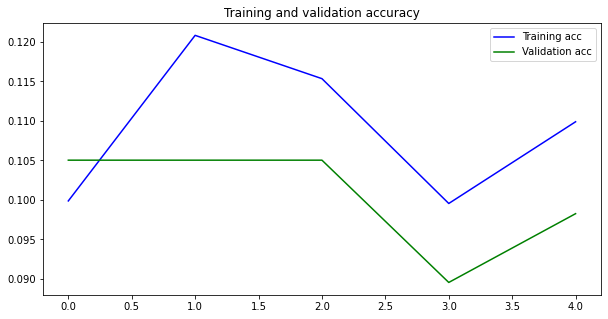

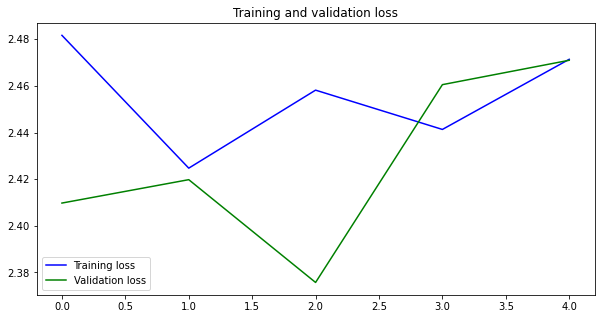

In [273]:
def plot_history(history):
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    #plt.figure()
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)

In [274]:
scores = model_02.evaluate(val_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

98/98 [==============================] - 278s 3s/step - loss: 2.4707 - accuracy: 0.0981
Accuracy: 9.81%


# Step 2

In [275]:
base_model_02.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model_02.layers)//2

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model_02.layers[:fine_tune_at]:
  layer.trainable =  False

In [276]:
len(base_model_02.trainable_variables)

357

In [277]:
for layer in model_02.layers:
    print(layer, layer.trainable)

<keras.engine.functional.Functional object at 0x00000216B4361FD0> True
<keras.layers.pooling.GlobalAveragePooling2D object at 0x00000216B4252FD0> True
<keras.layers.core.dense.Dense object at 0x00000216239D4580> True


In [278]:
LR=0.0001
model_02.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

In [279]:
model_02.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional)  (None, 3, 4, 2560)       64097687  
                                                                 
 global_average_pooling2d_17  (None, 2560)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_14 (Dense)            (None, 10)                25610     
                                                                 
Total params: 64,123,297
Trainable params: 59,262,562
Non-trainable params: 4,860,735
_________________________________________________________________


In [280]:
scores = model_02.evaluate(val_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

98/98 [==============================] - 272s 3s/step - loss: 2.4707 - accuracy: 0.0981
Accuracy: 9.81%


In [281]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]


In [282]:
# Обучаем
history = model_02.fit(
                    train_generator,
                    steps_per_epoch = train_generator.samples//train_generator.batch_size,
                    validation_data = val_generator, 
                    validation_steps = val_generator.samples//val_generator.batch_size,
                    epochs = 5,
                    callbacks=callbacks_list
                    )

Epoch 1/5
86/97 [=========================>....] - ETA: 1:49 - loss: 2.3563 - accuracy: 0.0965

KeyboardInterrupt: 

In [ ]:
def plot_history(history):
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    #plt.figure()
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)

# Step 3

In [ ]:
base_model_02.trainable = True
LR=0.00001
model_02.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])
history = model_02.fit(
                    train_generator,
                    steps_per_epoch = train_generator.samples//train_generator.batch_size,
                    validation_data = val_generator, 
                    validation_steps = val_generator.samples//val_generator.batch_size,
                    epochs = 5,
                    callbacks=callbacks_list
                    )

In [ ]:
def plot_history(history):
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    #plt.figure()
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)

In [ ]:
predictions_02 = model_02.predict(sub_generator) 
predictions_02

In [ ]:
predictions_02.shape

In [ ]:
predictions_02_ = np.argmax(predictions_02, axis=-1)
predictions_02_

In [ ]:
#predictions = model.predict(sub_generator, verbose=1)
#predictions = predictions.argmax(axis=1)

submission_02 = pd.DataFrame({
    'Id': sub_generator.filenames,
    'Category': predictions_02_
}, columns=['Id', 'Category'])
submission.to_csv('submission_02.csv', index=False)

In [ ]:
#model_02.save('../working/model_step1.hdf5')
#model_02.load_weights('best_model.hdf5')

In [ ]:
#model_02 = model_02.load_weights(checkpoint_filepath)